In [1]:
import polars as pl
import polars_ols as pls
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
df = pl.read_parquet("pga_results_1990_to_2024.pq")

In [3]:
df = df.with_columns(
    pl.col("year").cast(int).alias("int_year"),
    pl.col("final_position").str.extract("(\d+)").cast(int).alias("int_final_position"),
    pl.when(
        pl.col("tournament_name").is_in(
            [
                "masters_tournament",
                "the_open_championship",
                "us_open",
                "the_players_championship",
            ]
        )
    )
    .then(True)
    .otherwise(False)
    .alias("is_major"),
)

# Tournament Performance

In [4]:
# year_avg = (
#     df.filter(pl.col("int_final_position") == 1)
#     .group_by(["int_year"])
#     .agg([pl.col("total_relative").mean()])
#     .sort(by="int_year")
# )

# x, y = year_avg["int_year"].to_numpy(), year_avg["total_relative"].to_numpy()
# x = sm.tools.add_constant(x)

# lr = sm.regression.linear_model.OLS(y, x).fit()

# print(lr.summary())

shape: (2, 8)
┌──────────┬──────────┬──────────┬─────────────┬─────────────┬─────────────┬────────────┬──────────┐
│ r2       ┆ mae      ┆ mse      ┆ feature_nam ┆ coefficient ┆ standard_er ┆ t_values   ┆ p_values │
│ ---      ┆ ---      ┆ ---      ┆ es          ┆ s           ┆ rors        ┆ ---        ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ ---         ┆ ---         ┆ ---         ┆ f64        ┆ f64      │
│          ┆          ┆          ┆ str         ┆ f64         ┆ f64         ┆            ┆          │
╞══════════╪══════════╪══════════╪═════════════╪═════════════╪═════════════╪════════════╪══════════╡
│ 0.446632 ┆ 0.996369 ┆ 1.453603 ┆ x           ┆ -0.107248   ┆ 0.020781    ┆ -5.160891  ┆ 0.000011 │
│ 0.446632 ┆ 0.996369 ┆ 1.453603 ┆ intercept   ┆ -11.925698  ┆ 0.410917    ┆ -29.022146 ┆ 0.0      │
└──────────┴──────────┴──────────┴─────────────┴─────────────┴─────────────┴────────────┴──────────┘


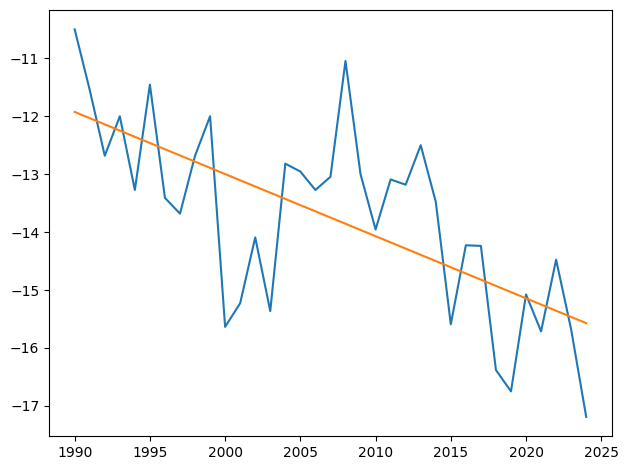

In [13]:
yearly_average_score = (
    df.filter(pl.col("int_final_position") == 1)
    .group_by(["int_year"])
    .agg([pl.col("total_relative").mean()])
    .sort(by="int_year")
)

coef_stats = yearly_average_score.select(
    pl.col("total_relative").least_squares.ols(
        pl.col("int_year").sub(pl.col("int_year").min()).alias("x"),
        pl.lit(1).alias("intercept"),
        mode="statistics",
    )
).unnest("statistics")

list_columns = [col for col, dtype in coef_stats.schema.items() if dtype == pl.List]
coef_stats = coef_stats.explode(list_columns)

print(coef_stats)

intercept = coef_stats.filter(pl.col("feature_names") == "intercept")[
    "coefficients"
].to_numpy()
x_coef = coef_stats.filter(pl.col("feature_names") == "x")["coefficients"].to_numpy()

x = yearly_average_score["int_year"].to_numpy()
y = yearly_average_score["total_relative"].to_numpy()

plt.plot(x, y)
plt.plot(x, (x - x.min()) * x_coef + intercept)

plt.tight_layout()
plt.show()

In [6]:
tournament_yearly_score = (
    df.filter([pl.col("int_final_position") == 1])
    .group_by(["tournament_name", "int_year"])
    .agg([pl.col("total_relative").mean()])
)

tournament_direction = (
    tournament_yearly_score.group_by(["tournament_name"])
    .agg(
        [
            pl.col("total_relative").least_squares.ols(
                pl.col("int_year").sub(pl.col("int_year").min()).alias("x"),
                mode="coefficients",
                add_intercept=True,
            ),
            pl.col("int_year").n_unique().alias("n_tournaments_hosted"),
        ]
    )
    .unnest("coefficients")
    .rename({"x": "coef", "const": "intercept"})
    .sort(by="coef", descending=True)
)

In [255]:
print("top 10 positively trending tournaments\n")

tournament_direction.head(10)

top 10 positively trending tournaments



tournament_name,coef,intercept,n_tournaments_hosted
str,f64,f64,u32
"""valero_texas_open""",0.138925,-18.63214,34
"""arnold_palmer_invitational_pre…",0.122689,-14.971429,35
"""the_memorial_tournament_presen…",0.082073,-15.22381,35
"""cognizant_classic_in_the_palm_…",0.07591,-12.947619,35
"""masters_tournament""",-0.008314,-10.803014,34
"""texas_childrens_houston_open""",-0.031322,-14.243287,34
"""charles_schwab_challenge""",-0.033333,-12.747619,35
"""pga_championship""",-0.043978,-10.109524,35
"""the_players_championship""",-0.072005,-11.921102,34


In [256]:
print("top 10 negatively trending tournaments\n")

tournament_direction.tail(10).sort(by="coef")

top 10 negatively trending tournaments



tournament_name,coef,intercept,n_tournaments_hosted
str,f64,f64,u32
"""tour_championship""",-0.37507,-6.480952,35
"""the_cj_cup_byron_nelson""",-0.300333,-9.773871,34
"""john_deere_classic""",-0.276777,-14.165331,34
"""wyndham_championship""",-0.246499,-12.92381,35
"""rbc_canadian_open""",-0.243459,-10.242203,33
"""zurich_classic_of_new_orleans""",-0.235043,-13.166667,27
"""travelers_championship""",-0.228291,-11.004762,35
"""fedex_st_jude_championship""",-0.20084,-9.985714,35
"""sanderson_farms_championship""",-0.193883,-14.468995,33


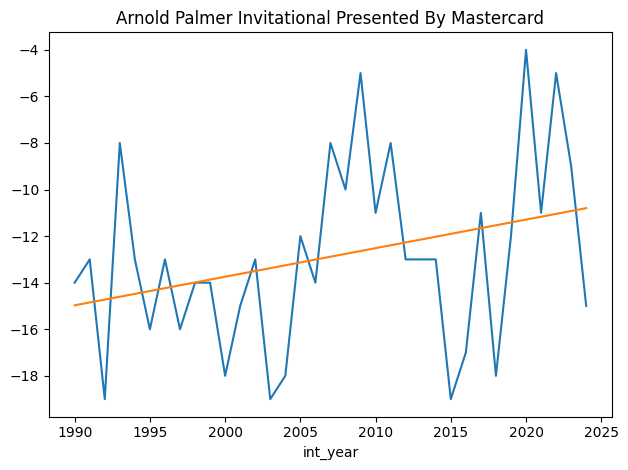

In [ ]:
target = "arnold_palmer_invitational_presented_by_mastercard"

specific_tournament = tournament_yearly_score.filter(
    pl.col("tournament_name") == target
).sort(by="int_year")

specific_tournament.to_pandas().set_index("int_year")["total_relative"].plot(
    title=" ".join(target.split("_")).title()
)

lr = (
    specific_tournament["int_year"].to_numpy()
    - specific_tournament["int_year"].to_numpy().min()
) * tournament_direction.filter(pl.col("tournament_name") == target)[
    "coef"
].to_numpy() + tournament_direction.filter(
    pl.col("tournament_name") == target
)[
    "intercept"
].to_numpy()

plt.plot(specific_tournament["int_year"].to_numpy(), lr)

plt.tight_layout()

# Player Performance

In [234]:
player_direction = (
    df.group_by(["player", "int_year"])
    .agg([pl.col("total_relative").mean().alias("avg_score")])
    .group_by(["player"])
    .agg(
        [
            pl.col("avg_score").least_squares.ols(
                pl.col("int_year").sub(pl.col("int_year").min()),
                mode="coefficients",
                add_intercept=True,
            ),
            pl.col("int_year").min().alias("first_year"),
            pl.col("int_year").max().alias("last_year"),
            pl.col("int_year").n_unique().alias("years_played"),
        ]
    )
    .unnest("coefficients")
    .rename({"int_year": "coef", "const": "intecept"})
    .filter(pl.col("years_played") > 5)
    .sort(by="coef", descending=True)
)

In [235]:
print("top 10 positively trending players\n")

player_direction.head(10)

top 10 positively trending players



player,coef,intecept,first_year,last_year,years_played
str,f64,f64,i64,i64,u32
"""Mike McCullough""",3.557143,-6.142857,1990,1995,6
"""Luke Guthrie""",2.262773,-7.019723,2012,2019,6
"""Jazz Janewattananond""",2.208571,2.627143,2017,2023,6
"""Ron Streck""",1.693548,0.370968,1990,1999,9
"""Lanny Wadkins""",1.677173,-3.003685,1990,2001,12
"""Dennis Trixler""",1.609459,-1.935135,1990,1997,6
"""Leigh Brannan""",1.606115,2.830935,1993,2002,7
"""Anthony Kim""",1.602041,-5.4427,2006,2012,7
"""Billy Casper""",1.594039,5.672573,1990,2005,12


In [236]:
print("top 10 negatively trending players\n")

player_direction.tail(10).sort(by="coef")

top 10 negatively trending players



player,coef,intecept,first_year,last_year,years_played
str,f64,f64,i64,i64,u32
"""Kevin Yu""",-3.446929,14.540373,2018,2024,6
"""Lucas Herbert""",-2.489881,11.281548,2018,2024,7
"""Sam Burns""",-2.36565,13.797442,2015,2024,9
"""Dean Burmester""",-2.184265,11.52795,2018,2024,6
"""Cole Hammer""",-2.029508,17.672131,2015,2024,6
"""Rik Massengale""",-1.728571,13.428571,1993,1999,6
"""Satoshi Kodaira""",-1.70188,16.258416,2013,2023,9
"""Grayson Murray""",-1.629563,15.461111,2013,2024,9
"""Alex Prugh""",-1.585251,13.434902,2007,2019,7
